# U-Net: Convolutional Networks for Biomedical Image Segmentation

## Overview

In the following we will implement Unet in pytorch and train on the dataset used by the authors of [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007%2F978-3-319-24574-4_28)

### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython.display import display # to display images

import albumentations as A
import gc
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

from collections import defaultdict

## Unet Implementation

The architecture of the model is the following:

![Unet](unet_arch.png)

It consists of a contracting path (left side) and an expansive path (right side). The constrasting path follows the typical architecture of a convolutional neural network, and it consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.

We will implement a class for the basic block, and one class for each of the sides. All of this will come together in the Unet class:

In [2]:
class Block(nn.Module):
    ''' One block of Unet.
        Contains 2 repeated 3 x 3 unpadded convolutions, each followed by a ReLU.
    '''
    
    def __init__(self, in_channel, out_channel, kernel_size):
        ''' Initialisation '''

        super().__init__()
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size)
        self.relu   = nn.ReLU()
        
        # Initialise weights on convolutional layers        
        nn.init.normal_(self.conv_1.weight, mean = 0.0, std = self.init_std(in_channel, kernel_size))
        nn.init.normal_(self.conv_1.weight, mean = 0.0, std = self.init_std(out_channel, kernel_size))
    
    
    @staticmethod
    def init_std(channels, kernel_size):
        ''' Computes std for weight initialisation on the convolutional layers'''
        return 2.0 / np.sqrt(channels * kernel_size ** 2)
    
        
    def forward(self, x):
        ''' Forward Phase '''
        
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.relu(x)
        
        return x


class Encoder(nn.Module):
    ''' Contractive Part of Unet '''
    
    def __init__(self, channels):
        '''Initialisation'''
        
        super().__init__()
        
        # Make block list
        modules = []
        
        for in_channel, out_channel in zip(channels[:-1], channels[1:]):
            block    = Block(in_channel = in_channel, out_channel = out_channel, kernel_size = 3)
            modules.append(block)
        
        self.blocks    = nn.ModuleList(modules = modules)
        self.max_pol   = nn.MaxPool2d(kernel_size = 2, stride = None)
        self.feat_maps = [] # Feature map of each block to be concatenated with the decoder part
    
    def forward(self, x):
        '''Forward phase'''
        
        for layer_no, layer in enumerate(self.blocks):
        
            # Run block
            x = layer(x)
            
            if not self.is_final_layer(layer_no):
                
                # Store feature maps for the decoder
                self.feat_maps.append(x)
                
                # Perform max pooling operation
                x = self.max_pol(x)
        
        return x
    
    def is_final_layer(self, layer_no):
        return layer_no == len(self.blocks) - 1

    
class Decoder(nn.Module):
    ''' Expansive Part of Unet '''
    
    def __init__(self, channels):
        '''Initialisation'''
        
        super().__init__()
        
        # Make module lists
        up_convs = []
        blocks   = []
        for in_channel, out_channel in zip(channels[:-1], channels[1:]):
            
            # 2x2 Upconvolution
            upconv = nn.ConvTranspose2d(in_channel, out_channel, kernel_size = 2, stride = 2)
            up_convs.append(upconv)
            
            # Block (2 convolutions with ReLUs)
            block = Block(in_channel, out_channel, kernel_size = 3)
            blocks.append(block)
    
        # Make modules
        self.upconvs = nn.ModuleList(up_convs)
        self.blocks  = nn.ModuleList(blocks)
        
        
    def forward(self, x, encoded_feat_maps):
        
        for upconv, block in zip(self.upconvs, self.blocks):
            
            # Apply upconvolution
            x = upconv(x)
            
            # Grab corresponding feature map from the encoder
            fts = encoded_feat_maps.pop()

            # Crop it
            fts = self.crop(fts, x.shape[2], x.shape[3])
            
            # Concatenate it to the input
            x = torch.cat([x, fts], dim = 1)
            
            # Perform convs with ReLUs
            x = block(x)
            
        return x
            
    @staticmethod
    def crop(tnsr, new_H, new_W):
        ''' Center crop an input tensor to shape [hew_H, hew_W] '''
        
        # Grab existing size
        _, _, H, W = tnsr.size()

        # Compute one corner of the image
        x1 = int(round( (H - new_H) / 2.))
        y1 = int(round( (W - new_W) / 2.))

        # Compute the other one
        x2 = x1 + new_H
        y2 = y1 + new_W

        return tnsr[:, :, x1:x2, y1:y2]


class Unet(nn.Module):
    ''' Unet class
        As suggested in "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597.pdf)
    '''
    
    def __init__(self, channels, no_classes, output_size = None):
        '''Initialisation'''
        
        super().__init__()
        
        self.output_size = output_size
        
        # Initialise encoder
        self.encoder = Encoder(channels)
        
        # Initialise decoder
        dec_channels = list(reversed(channels[1:])) # Flip the channels for the contractive part (and omit the first one)
        self.decoder = Decoder(dec_channels) 
        
        # Initialise final layer
        self.head    = nn.Conv2d(in_channels = channels[1], out_channels = no_classes, kernel_size = 1)
    
    
    def forward(self, x):
        '''Forward Phase'''
        
        x = self.encoder(x)
        x = self.decoder(x, self.encoder.feat_maps)
        x = self.head(x)
        
        # Retain dimensions
        if self.output_size is not None:
            x = F.interpolate(x, self.output_size)
        
        return x
        

Let's make sure it works. We'll check if the output dimensions of the tensors match the ones mentioned in Figure 1 when using the same architecture and same size inputs

In [3]:
x   = torch.Tensor(np.random.rand(2, 3, 572, 572))
ch  = [3, 64, 128, 256, 512, 1024]
net = Unet(channels = ch, no_classes = 4)
x   = net(x)
print(x.shape)

x   = torch.Tensor(np.random.rand(3, 1, 572, 572))
ch  = [1, 64, 128, 256, 512]
net = Unet(channels = ch, no_classes = 2, output_size = (572,572))
x   = net(x)
print(x.shape)

del x, net
gc.collect();

torch.Size([2, 4, 388, 388])
torch.Size([3, 2, 572, 572])


Perfect.

## Training on the 2012 EM Segmentation Challenge 

A test case example of the paper was the [ISBI 2012 challenge](http://brainiac2.mit.edu/isbi_challenge/). This dataset contains 30 ssTEM (serial section Transmission Electron Microscopy) 512x512 images taken from the Drosophila larva ventral nerve cord (VNC). The images represent a set of consecutive slices within one 3D volume. The microcube measures 2 x 2 x 1.5 microns approx., with a resolution of 4x4x50 nm/pixel.

The corresponding binary labels are provided in an in-out fashion, i.e. white for the pixels of segmented objects and black for the rest of pixels (which correspond mostly to membranes).

30 512x512 images of 1 channel can easily fit to memory, so we can load the entire dataset once. 
Let's read the data and visualise an example:

In [4]:
datadir  = './data/images/'
labeldir = './data/labels/'

# Channel and image dimensions (from the data decription)
C, H, W = 1, 512, 512

img_mtrx  = np.empty(shape = (30, H, W), dtype = np.uint8)
mask_mtrx = np.empty(shape = (30, H, W))

# Loop over all image / mask pairs
for i, (img, lab) in enumerate(zip(os.listdir(datadir), os.listdir(labeldir))):
        
    # Load image
    image = np.array(Image.open(datadir + img))
    
    # Add channel dimension
    image = np.expand_dims(image, axis = 0)
    
    # Add to matrix
    img_mtrx[i, :, :] = image 
    
    # Load mask in grayscale (single channel)
    mask = cv2.imread(labeldir + lab, cv2.IMREAD_GRAYSCALE)
   
    # Binarise
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        
    # Add to matrix
    mask_mtrx[i, :, :] = mask 


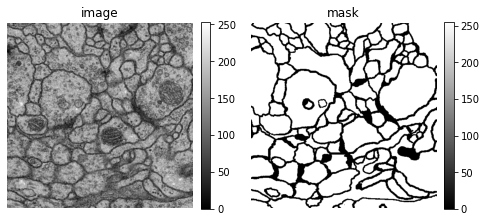

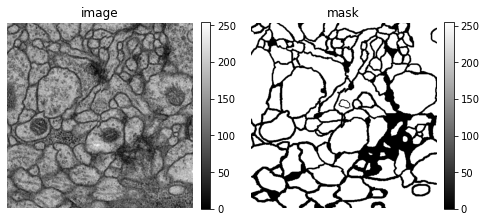

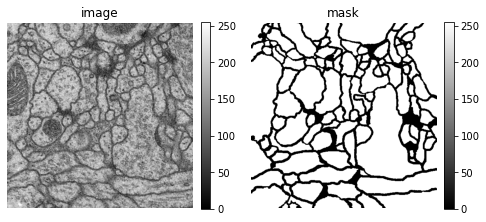

In [5]:
# Plot a few examples
for i in [1, 5, 10]:
    fig, ax = plt.subplots(1, 2, figsize = (8, 8))
    
    im = ax[0].imshow(img_mtrx[i, :, :], 'gray')
    plt.colorbar(im, ax = ax[0], fraction = 0.046, pad = 0.04)
    ax[0].axis('off')
    ax[0].set_title('image')

    im = ax[1].imshow(mask_mtrx[i, :, :], 'gray')
    plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)
    ax[1].axis('off')
    ax[1].set_title('mask')

## Weight map

Authors precompute the weight map for each ground truth segmentation to compensate the different frequency of pixels from a certain class in the training dataset, in order to force the network to learn the small separation borders that they introduce between touching cells.
The separation border is computed using morphological operations, and subsequently the weight map is the computed as:

$w(\mathbf{x}) = w_c(\mathbf{x}) + w_0 \exp \left( - \frac{\left[ d_1(x) + d_2(x)\right]^2}{2\sigma^2} \right) $

where $w_c: \Omega \rightarrow \mathbb{R}$ is the weight map to balance the class fequencies, $d_1:\Omega \rightarrow \mathbb{R}$ is the distance to the border of the nearest cell, and  $d_2:\Omega \rightarrow \mathbb{R}$ is the distance to the border of the second nearest cell.

First we need a function to compute $w_c$:

In [6]:
def class_weights(mask):
    ''' Create a dictionary containing the classes in a mask,
        and their corresponding weights to balance their occurence
    '''
    
    wc = defaultdict()

    # Grab classes and their corresponding counts
    unique, counts = np.unique(mask, return_counts = True)

    # Convert counts to frequencies
    counts = counts / np.product(mask.shape)

    # Get max. counts
    max_count = max(counts)

    for val, count in zip(unique, counts):
        wc[val] = max_count / count
    
    return wc

Next, we need to compute the rightmost term of the above equation:

In [7]:
def weight_map(mask, w0, sigma, background_class = 0):
    
    # Fix mask datatype (should be unsigned 8 bit)
    if mask.dtype != 'uint8': 
        mask = mask.astype('uint8')
    
    # Weight values to balance classs frequencies
    wc = class_weights(mask)
    
    # Assign a different label to each connected region of the image
    _, regions = cv2.connectedComponents(mask)
    
    # Get total no. of connected regions in the image and sort them excluding background
    region_ids = sorted(np.unique(regions))
    region_ids = [region_id for region_id in region_ids if region_id != background_class]
        
    if len(region_ids) > 1: # More than one connected regions

        # Initialise distance matrix (dimensions: H x W x no.regions)
        distances = np.zeros((mask.shape[0], mask.shape[1], len(region_ids)))

        # For each region
        for i, region_id in enumerate(region_ids):

            # Mask all pixels belonging to a different region
            m = (regions != region_id).astype(np.uint8)# * 255
        
            # Compute Euclidean distance for all pixels belongind to a different region
            distances[:, :, i] = cv2.distanceTransform(m, distanceType = cv2.DIST_L2, maskSize = 0)

        # Sort distances w.r.t region for every pixel
        distances = np.sort(distances, axis = 2)

        # Grab distance to the border of nearest region
        d1, d2 = distances[:, :, 0], distances[:, :, 1]

        # Compute RHS of weight map and mask background pixels
        w = w0 * np.exp(-1 / (2 * sigma ** 2)  * (d1 + d2) ** 2) * (regions == background_class)

    else: # Only a single region present in the image
        w = np.zeros_like(mask)

    # Instantiate a matrix to hold class weights
    wc_x = np.zeros_like(mask)
    
    # Compute class weights for each pixel class (background, etc.)
    for pixel_class, weight in wc.items():
    
        wc_x[mask == pixel_class] = weight
    
    # Add them to the weight map
    w = w + wc_x
    
    return w

Let's check a few examples:

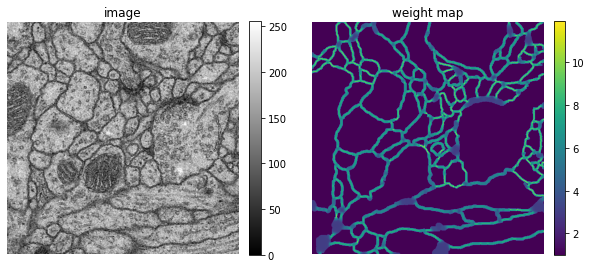

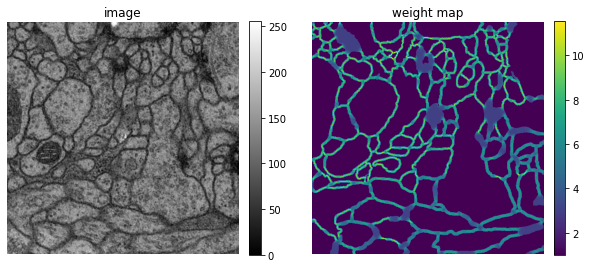

In [8]:
# Parameters used by the authors
w0    = 10
sigma = 5

for i in np.random.randint(0, img_mtrx.shape[0], 2): # Randomly draw 3 images
    
    # Grab image and label map
    mask = mask_mtrx[i, :, :]
    img  = img_mtrx[i, :, :]

    # Compute weight map
    w = weight_map(mask = mask, w0 = w0, sigma = sigma)
    
    # Plot results
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10));

    im = ax[0].imshow(img, 'gray')
    plt.colorbar(im, ax = ax[0], fraction = 0.046, pad = 0.04)
    ax[0].axis('off')
    ax[0].set_title('image')

    im = ax[1].imshow(w)
    plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)
    ax[1].axis('off');
    ax[1].set_title('weight map');

Very good

### Data Augmentation

According to the authors we need:
Shift and rotation invariance as well as robustness to deformations and gray value variations. 
Especially random elastic deformations of the training samples were found to be the key concept to train a segmentation network with very few annotated images.

Let's define the transformations:

In [9]:
# Define augmentation pipelines
p = 0.95
train_transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p = p),
        A.VerticalFlip(p = p),
        A.Transpose(p = p),
        A.RandomRotate90(p = p),
        A.ShiftScaleRotate(p = p, shift_limit = 0.0625, scale_limit = 0.1, rotate_limit = 45)
    ], p = 1),
    A.GaussNoise(p = p, var_limit = (0, 20), mean = 0, per_channel = True),
    A.MultiplicativeNoise(p = p, multiplier=(0.9, 1.1), elementwise = True),
    A.ElasticTransform(p = p, alpha = 35, sigma = 5, alpha_affine = 3, approximate = True),
    A.RandomBrightnessContrast(p = p, brightness_limit = 0.15, contrast_limit = 0.15),
    A.PadIfNeeded(p = 1, min_height = 128, min_width = 128, border_mode = cv2.BORDER_REFLECT)
])


Let's have a look:

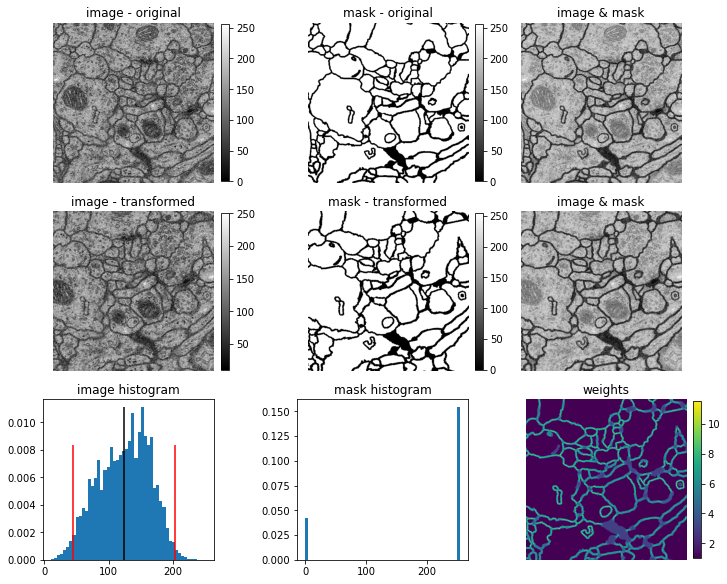

In [10]:
# Parameters recommended by the authors
w0   = 10
sigma = 5

for i in np.random.randint(0, 30, 1): # Randomly draw 1 image
    
    # Grab image and label map
    mask = mask_mtrx[i, :, :]
    img  = img_mtrx[i, :, :]
    
    # Apply transformations
    aug     = train_transform(image = img, mask = mask)
    img_t   = aug["image"]
    mask_t  = aug["mask"]
    
    # Compute weight map
    weights = weight_map(mask = mask_t, w0 = w0, sigma = sigma)

    # Plot
    fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (10,8), constrained_layout=True)
    
    im = ax[0, 0].imshow(img, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[0, 0], fraction = 0.046, pad = 0.04)
    ax[0, 0].axis('off');
    ax[0, 0].set_title('image - original')
    
    im = ax[0, 1].imshow(mask, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[0, 1], fraction = 0.046, pad = 0.04)
    ax[0, 1].axis('off');
    ax[0, 1].set_title('mask - original')
    
    ax[0, 2].imshow(img, 'gray', interpolation = None)
    ax[0, 2].imshow(mask, 'gray', interpolation = None, alpha = 0.3)
    ax[0, 2].axis('off');
    ax[0, 2].set_title('image & mask')
            
    im = ax[1, 0].imshow(img_t, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[1, 0], fraction = 0.046, pad = 0.04)
    ax[1, 0].axis('off');
    ax[1, 0].set_title('image - transformed')
    
    im = ax[1, 1].imshow(mask_t, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[1, 1], fraction = 0.046, pad = 0.04)
    ax[1, 1].axis('off');
    ax[1, 1].set_title('mask - transformed')
    
    ax[1, 2].imshow(img_t, 'gray', interpolation = None)
    ax[1, 2].imshow(mask_t, 'gray', interpolation = None, alpha = 0.3)
    ax[1, 2].axis('off');
    ax[1, 2].set_title('image & mask')
    
    counts, _, _ = ax[2, 0].hist(img_t.reshape(-1, 1), bins = 50, density = True);
    ax[2, 0].vlines(img_t.mean(), 0, max(counts), colors='k')
    ax[2, 0].vlines(img_t.mean() + 2 * np.std(img_t), 0, max(counts) * 0.75, colors='r')
    ax[2, 0].vlines(img_t.mean() - 2 * np.std(img_t), 0, max(counts) * 0.75, colors='r')
    ax[2, 0].set_title('image histogram')
    
    ax[2, 1].hist(mask_t.reshape(-1, 1), bins = 50, density = True);
    ax[2, 1].set_title('mask histogram')
    
    im = ax[2, 2].imshow(weights, interpolation = None)
    plt.colorbar(im, ax = ax[2, 2], fraction = 0.046, pad = 0.04)
    ax[2, 2].axis('off');
    ax[2, 2].set_title('weights')

Perfect. We can start training.

## Dataset class

Let's make the dataset class:

In [11]:
class SegmentationDataset(Dataset):
    
    def __init__(self, images, masks, wmap_w0, wmap_sigma, device, transform = None):
        ''' Initialisation function '''
        
        self.images    = images
        self.masks     = masks
        self.transform = transform
        self.device    = device
        
        # Parameters for weight map calculation
        self.w0    = wmap_w0
        self.sigma = wmap_sigma

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        ''' Preprocess and return image, mask, and weight map '''
        
        image = self.images[idx, :, :]
        mask  = self.masks[idx, :, :]
        
        if self.transform:
            
            # Apply transformations
            aug   = self.transform(image = img, mask  = mask)
            image = aug["image"]
            mask  = aug["mask"]
        
        # Compute weight map
        weights = weight_map(mask = mask, w0 = self.w0, sigma = self.sigma)
        
        # Min-max scale image and mask
        image = self.min_max_scale(image, min_val = 0, max_val = 1)
        mask  = self.min_max_scale(mask,  min_val = 0, max_val = 1)
        
        # Add channel dimensions
        image   = np.expand_dims(image,   axis = 0)
        weights = np.expand_dims(weights, axis = 0)
        mask    = np.expand_dims(mask,    axis = 0)
        
        # Convert to tensors and send to device
        weights = torch.from_numpy(weights).double().to(device)
        image   = torch.from_numpy(image).double().to(device)
        mask    = torch.from_numpy(mask).double().to(device)
        
        # Center crop mask and weights (negative padding = cropping - size defined manually)
        mask    = nn.ZeroPad2d(-94)(mask)
        weights = nn.ZeroPad2d(-94)(weights)
        
        return image, mask, weights
    
    @staticmethod
    def min_max_scale(image, max_val, min_val):
        '''Normalization to range of min, max'''
        
        image_new = (image - np.min(image)) * (max_val - min_val) / (np.max(image) - np.min(image)) + min_val
        return image_new

### Loss function

We also need a pixel-wise weighted negative log loss, which unfortunately does not exist in pytorch. Implementing one is pretty straightforward:

In [12]:
class WeightedBCEWithLogitsLoss(nn.Module):
    ''' Pixel-wise weighted BCEWithLogitsLoss'''
    
    def __init__(self, batch_size):
        
        super().__init__()
        self.batch_size = batch_size
        self.unw_loss = nn.BCEWithLogitsLoss(reduction = 'none')
    
    def __call__(self, true, predicted, weights):
        
        # Compute weighted loss
        loss = self.unw_loss(predicted, true) * weights
        
        # Sum over all channels
        loss = loss.sum(dim = 1)
        
        # Flatten and rescale so that loss is approx. in the same interval
        loss = loss.view(self.batch_size, -1) / weights.view(self.batch_size, -1)
        
        # Average over mini-batch
        loss = loss.mean()

        return loss

### Learning rate range test

The authors mention that they used SGD with a batchsize equal to 1 and momentum equal to 0.99. They do not mention the learning rate though.
Let's conduct an [LR test](https://arxiv.org/pdf/1506.01186.pdf) to find a good learning rate.
First, let's make a class for the learning rate range test:

In [13]:
class LRTest(object):
    
    def __init__(self, min_lr, max_lr, no_iter, batch_size):
        ''' Initialisation function '''
        
        self.batch_size    = batch_size
        self.no_iter       = no_iter
        self.lr_multiplier = (max_lr / min_lr) ** (1 / (no_iter))
        self.dataiter      = None
        

    # Function to perform the learning rate range test on one experiment
    def __call__(self, dataloader, criterion, optimizer, model):
        ''' LR Range test '''
        
        # Set model to training mode
        model.train()
        
        # Configure scheduler
        scheduler  = optim.lr_scheduler.ExponentialLR(optimizer, gamma = self.lr_multiplier)
        
        # Empty lists to hold results
        loss_arr, lr_arr     = [], []
        
        # Counters' initialisation
        cur_iter, best_loss  = 0, 1e9
        
        with tqdm(total = self.no_iter) as pbar:
            
            while cur_iter < self.no_iter:
                
                # Grab learning rate (before stepping the scheduler)
                lr_arr.append(scheduler.get_lr())
                
                # Train a batch
                cur_loss = self.train_batch(model, criterion, optimizer, scheduler, dataloader)
                
                # Append loss
                loss_arr.append(cur_loss)

                # Check for divergence and exit if needed
                if cur_loss < best_loss: 
                    best_loss = cur_loss

                if cur_loss > 2e2 * best_loss: # Divergence
                    print('Diverged on iteration ' + str(cur_iter) + ' with loss ' + str(cur_loss))
                    break

                # Update progress bar
                pbar.set_postfix(loss = cur_loss)
                pbar.update(1)
                cur_iter += 1

        pbar.close() # Close

        return lr_arr, loss_arr
    
    
    # Return a batch
    def grab_batch(self, dataloader):
        
        # Lazy init
        if self.dataiter is None:
            self.dataiter = iter(dataloader)
        
        # Get next batch
        try:
            X, y, w = next(self.dataiter)
            
        except: # End of dataset -> restart
            
            self.dataiter = iter(dataloader)
            X, y, w  = next(self.dataiter)
        
        return X, y, w
    
    
    # Train batch
    def train_batch(self, model, criterion, optimizer, scheduler, dataloader):

        optimizer.zero_grad()
        
        cur_iter = 0
        run_loss = 0
        while cur_iter < self.batch_size:
        
            # Get sample
            X, y, w = self.grab_batch(dataloader)

            # Predict
            y_hat = model(X)
            
            # Compute normalised gradients
            loss  = criterion(y, y_hat, w) / self.batch_size
            run_loss += loss.item()
            
            # Backprop
            loss.backward()
            
            # Update counter
            cur_iter += 1
        
        # Update
        optimizer.step()
        scheduler.step()

        return run_loss


Let's run it:

In [15]:
act_batch_size = 1 # Can't fit more than one image in GPU!
eff_batch_size = 1 # Efective batch (Gradient accumulation)
device        = 'cuda'
momentum      = 0.99
channels      = [C, 64, 128, 256, 512, 1024]
w0            = 10
sigma         = 5

min_lr  = 1e-6
max_lr  = 10
no_iter = 50

# Configure train test split
np.random.seed(123)
no_img    = img_mtrx.shape[0]
test_idx  = np.random.randint(0, no_img, 3) # Keep 3 images for test set
train_idx = np.setdiff1d(np.arange(0, no_img), test_idx)

# Make model
model     = Unet(channels = channels, no_classes = 1).double().to(device)

# Configure criterion
criterion = WeightedBCEWithLogitsLoss(batch_size = act_batch_size)

# Setup optimiser
optimizer = optim.SGD(model.parameters(), lr = min_lr, momentum = momentum)

# Make dataset
train_set = SegmentationDataset(images    = img_mtrx[train_idx, :, :],
                                masks     = mask_mtrx[train_idx, :, :],
                                transform = train_transform,
                                device = device, wmap_w0 = w0, wmap_sigma = sigma)

# Make dataloader
train_loader = DataLoader(dataset = train_set, batch_size = act_batch_size,
                          shuffle = True, num_workers = 0, pin_memory = False)

# Run LR range test
lr_test  = LRTest(min_lr = min_lr, max_lr = max_lr, no_iter = no_iter, batch_size = eff_batch_size)
lr, loss = lr_test(train_loader, criterion, optimizer, model)

  0%|          | 0/50 [00:00<?, ?it/s]

Diverged on iteration 43 with loss 1367209663.550878


Let's plot the results:

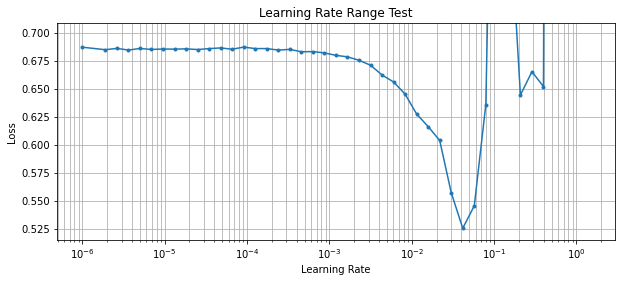

In [16]:
plt.figure(figsize = (10, 4))
plt.semilogx(lr, loss, marker = '.')
plt.ylim(min(loss) * 0.98, min(loss) * 1.35);
plt.title('Learning Rate Range Test')
plt.ylabel('Loss')
plt.xlabel('Learning Rate')
plt.grid(b = True, which='both', axis='both');

We could go with a learning rate of 1e-2

### Early stopping

We also need an early stopping class to monitor if the validation loss is decreasing and save the model accordingly:

In [20]:
class EarlyStopping(object):
    '''Early Stopping'''
    
    def __init__(self, patience, fname):
        self.patience  = patience
        self.best_loss = np.Inf
        self.counter   = 0
        self.filename  = fname
        
    def __call__(self, epoch, loss, optimizer, model):
        
        if loss < self.best_loss:
            self.counter = 0
            self.best_loss = loss
            
            torch.save({
                'epoch':                epoch,
                'model_state_dict':     model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss':                 loss,
            }, self.filename)
            
        else:
            self.counter += 1
        
        return self.counter == self.patience


### Training and validation functions

Let's also make the wrappers for the training and validation loops:

In [21]:
def train(model, optimizer, dataloader, criterion, effective_batch_size, p_bar = None):
    ''' Training '''
    
    model.train()
    optimizer.zero_grad()
    running_loss = 0
    
    for batch_id, (X, y, weights) in enumerate(dataloader):
        
        if p_bar is not None: 
            p_bar.set_description_str(f'Batch {batch_id + 1}')
            
        # Forward
        y_hat = model(X)
        
        # Compute loss
        loss = criterion(y, y_hat, weights) / effective_batch_size
        running_loss += loss.item()
        loss.backward()
        
        # Backprop
        if ( (batch_id + 1) % effective_batch_size == 0 ) or ( (batch_id + 1) == len(train_loader) ):
            optimizer.step()
            optimizer.zero_grad()
        
        # Update progress bar
        if p_bar is not None:
            p_bar.set_postfix(loss = loss.item())
            p_bar.update(1)
    
    # Compute average loss
    running_loss = running_loss /  len(dataloader) * effective_batch_size
        
    return running_loss

def validation(model, dataloader, criterion):
    ''' Validation '''
    
    # Validation
    model.eval()
    running_loss = 0
    
    # List to hold predictions of the model
    predictions = []
    
    with torch.no_grad():
        for batch_id, (X, y, weights) in enumerate(dataloader):

            # Forward
            y_hat = model(X)

            # Compute loss
            loss = criterion(y, y_hat, weights)
            running_loss += loss.item()

    # Compute average loss
    running_loss /= len(dataloader)
    
    return running_loss

### Training Loop

Now, we can put everything together. The authors report average performance over 7 rotations of the dataset. We'll just do one here to save time:

In [22]:
epochs         = 1000
learning_rate  = 1e-2
act_batch_size = 1 # Can't fit more than one image in GPU!
eff_batch_size = 1 # Efective batch (Gradient accumulation)
momentum       = 0.99
device         = 'cuda'
channels       = [C, 64, 128, 256, 512, 1024]
w0             = 10
sigma          = 5
model_path     = './model.pt'

# Early stopping
es = EarlyStopping(patience = 100, fname = model_path)

# Make datasets
train_set = SegmentationDataset(images    = img_mtrx[train_idx, :, :],
                                masks     = mask_mtrx[train_idx, :, :],
                                transform = train_transform,
                                device = device, wmap_w0 = w0, wmap_sigma = sigma)

test_set = SegmentationDataset(images    = img_mtrx[test_idx, :, :],
                               masks     = mask_mtrx[test_idx, :, :],
                               transform = None,
                               device = device, wmap_w0 = w0, wmap_sigma = sigma)

# Make dataloaders
train_loader = DataLoader(dataset     = train_set, 
                          batch_size  = act_batch_size, 
                          shuffle     = True,
                          num_workers = 0,     # Change to >0 for performance
                          pin_memory  = False) # Change to true for performance

test_loader  = DataLoader(dataset     = test_set,  
                          batch_size  = act_batch_size,
                          shuffle     = False, 
                          num_workers = 0,     # Change to >0 for performance
                          pin_memory  = False) # Change to true for performance

# Make progress bars
pbar_epoch = tqdm(total = epochs, unit = 'epoch', position = 0, leave = False)
pbar_train = tqdm(total = len(train_loader), unit = 'batch', position = 1, leave = False)

# Make model
model = Unet(channels = channels, no_classes = 1).double().to(device)

# Make optimiser
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

# Make loss
criterion = WeightedBCEWithLogitsLoss(batch_size = act_batch_size)

# Load checkpoint (if it exists)
cur_epoch = 0
if os.path.isfile(model_path):
    checkpoint   = torch.load(model_path)
    cur_epoch    = checkpoint['epoch']
    es.best_loss = checkpoint['loss']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Hold stats for training process
stats = {'epoch': [], 'train_loss': [], 'val_loss': []}

# Training  / validation loop
for epoch in range(cur_epoch, epochs):
    
    # Train / validate
    pbar_epoch.set_description_str(f'Epoch {epoch + 1}')
    train_loss = train(model, optimizer, train_loader, criterion, eff_batch_size, pbar_train)
    val_loss   = validation(model, test_loader, criterion)
    
    # Append stats
    stats['epoch'].append(epoch)
    stats['train_loss'].append(train_loss)
    stats['val_loss'].append(val_loss)
    
    # Early stopping (just saves model if validation loss decreases when: pass)
    if es(epoch, val_loss, optimizer, model): pass
    
    # Update progress bars
    pbar_epoch.set_postfix(train_loss = train_loss, val_loss = val_loss)
    pbar_epoch.update(1)
    pbar_train.reset()

  0%|          | 0/1000 [00:00<?, ?epoch/s]

  0%|          | 0/27 [00:00<?, ?batch/s]

Let's check the predictions on the validation set:

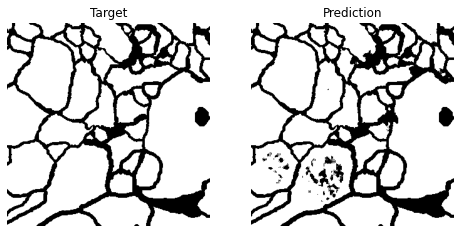

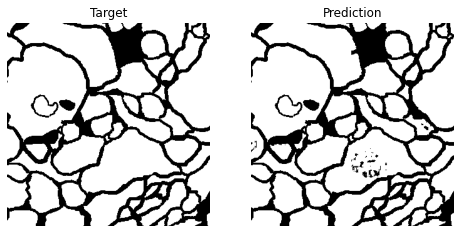

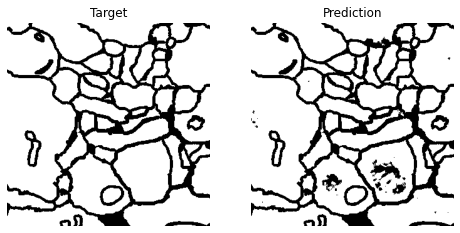

In [71]:
# load model

model      = Unet(channels = channels, no_classes = 1).double().to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Make loss
criterion = WeightedBCEWithLogitsLoss(batch_size = act_batch_size)
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    
    for batch_id, (X, y, weights) in enumerate(test_loader):

        # Forward
        y_hat = model(X)
        y_hat = torch.sigmoid(y_hat)
        
        
        # Convert to numpy
        X = np.squeeze(X.cpu().numpy())
        y = np.squeeze(y.cpu().numpy())
        w = np.squeeze(weights.cpu().numpy())
        y_hat = np.squeeze(y_hat.detach().cpu().numpy())
        
        # Make mask
        y_hat2 = y_hat > 0.5
    
        # plot
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 8))

        ax[0].imshow(y, 'gray', interpolation = None)
        ax[0].axis('off');
        ax[0].set_title('Target');

        ax[1].imshow(y_hat, 'gray', interpolation = None)
        ax[1].axis('off');
        ax[1].set_title('Prediction');

Not bad, not perfect either.